## Binary classification with CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed and tokenized. 
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model

### 1. Import libraries

In [188]:
from modules.bert_module import *
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np

### 2. Load tokenized data

In [189]:
train_data=joblib.load(os.path.join(tokenized_data_savepath,"train_data.joblib"))
test_data=joblib.load(os.path.join(tokenized_data_savepath,"test_data.joblib"))
val_data=joblib.load(os.path.join(tokenized_data_savepath,"val_data.joblib"))

### 3. Prepare data for CNN
- We extract only the signal data and labels from dataset for CNN
- We train using the training set and save the model that gives the best performance on the validation set

In [190]:
train_sigdata,train_label=prepare_cnn_data(val_data)
val_sigdata,val_label=prepare_cnn_data(train_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. ShallowConvNet model

- Paper: https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
- Pytorch conversion from keras implementation https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
- Another useful link: https://github.com/TNTLFreiburg/braindecode/tree/master/braindecode
- Pytorch implementation of the Shallow Convolutional Network as described in Schirrmeister et. al. (2017), Human Brain Mapping.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions.

- Assumes the input is a 5-second EEG signal sampled at 500Hz. 

- Note that we use the max_norm constraint on all convolutional layers, as well as the classification layer.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions. Instead, they can be implemented using hooks or by manually enforcing the constraint during the forward pass or after updating the weights. 
- Model was developed with hyperparameters from original paper
- examples are in: https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html#model-training

In [191]:
import torch
import torch.nn as nn

def max_norm(layer, max_value, axis=0):
    with torch.no_grad():
        norm = layer.weight.norm(2, axis, keepdim=True)
        desired = torch.clamp(norm, 0, max_value)
        scale = desired / (1e-8 + norm)
        layer.weight.data *= scale

class ShallowConvNet(nn.Module):
    def __init__(self, nb_classes, Chans=59, Samples=2500, dropoutRate=0.5):
        super(ShallowConvNet, self).__init__()
        self.Samples=Samples       
        # First Conv2D layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=40, kernel_size=(1, 25), padding=0)     
        # Second Conv2D layer
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(Chans, 1), bias=False)     
        # Batch Normalization
        self.batchnorm = nn.BatchNorm2d(num_features=40, eps=1e-05, momentum=0.9)     
        # Average Pooling
        self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))     
        # Dropout
        self.dropout = nn.Dropout(p=dropoutRate)    
        # Fully Connected Layer
        self.fc = nn.Linear(in_features=40* ((Samples - 24-74) // 15+1), out_features=nb_classes)
        
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
         # Size: (batch_size, 1, Chans, Samples)

        # First convolutional layer
        x = self.conv1(x)
        max_norm(self.conv1, 2.0, axis=(0, 1, 2))
        # Size: (batch_size, 40, Chans, Samples - 24)
        
        # Second convolutional layer
        x = self.conv2(x)
        max_norm(self.conv2, 2.0, axis=(0, 1, 2))
        # Size: (batch_size, 40, 1, Samples - 24)

        # Batch normalization
        x = self.batchnorm(x)     
        # Square activation
        x = torch.square(x)   
        
        # Average pooling
        x = self.pool(x) 
        # Size: (batch_size, 40, 1, (Samples - 24-74) // 15+1)
        
        # Log activation
        x = torch.log(x)   
        # Dropout
        x = self.dropout(x)  
        # Flatten
        x = x.view(-1, int(40* ((self.Samples - 24-74) // 15+1))) 
        # Size: (batch_size, 40 * (Samples - 24-74) // 15+1)

        # Fully connected layer
        x = self.fc(x)
        max_norm(self.fc, 0.5, axis=0)       
        
        return x

### 5. Initialize model

In [192]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = ShallowConvNet(nb_classes=2, Chans=n_chan, Samples=n_datalength, dropoutRate=0.5)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [193]:
#batch_size = 8#1
batch_size = 64 # from their doc website
num_epochs = 70 # utilized from CNN model of Oh et al. 2018
#num_epochs = 4 # from their website. This resulted in very littile training.
#lrate=5e-4
lrate=0.0625 * 0.01 # from their doc website
weight_decay = 0 # from their website
patience=80
# Define loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=lrate,weight_decay=weight_decay)
#criterion = nn.NLLLoss() # from their website
optimizer = optim.AdamW(model.parameters(), lr=lrate,weight_decay=weight_decay) # from their website
cnn_modelfullpath=os.path.join(cnn_modelpath,'shallownet.pt')

random_seed=42

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [194]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [195]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/70: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


model state saved with validation accuracy: 66.7702


Epoch 34/70: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


model state saved with validation accuracy: 68.0124


Epoch 37/70: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


model state saved with validation accuracy: 68.9441


Epoch 38/70: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


model state saved with validation accuracy: 72.6708


Epoch 43/70: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


model state saved with validation accuracy: 73.6025


Epoch 44/70: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


model state saved with validation accuracy: 74.2236


Epoch 45/70: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


model state saved with validation accuracy: 75.4658


Epoch 46/70: 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


model state saved with validation accuracy: 77.6398


Epoch 54/70: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


model state saved with validation accuracy: 78.2609


Epoch 70/70: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


### 9. Inspect training process

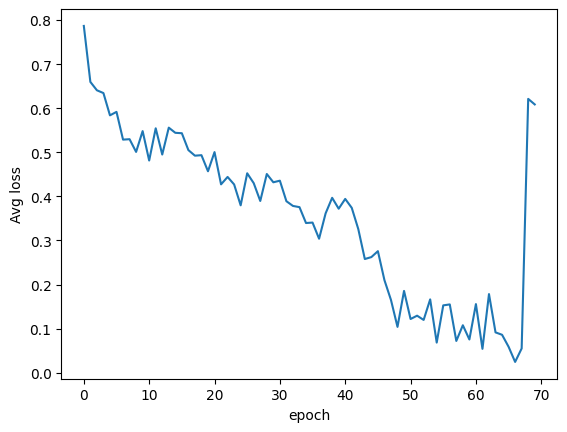

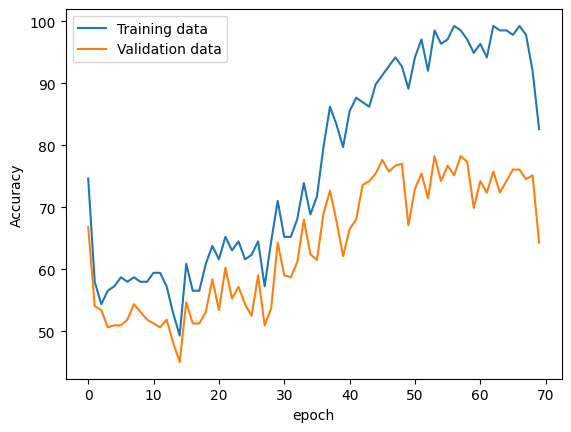

In [196]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [197]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 98.5507
Confusion Matrix:
[[70  2]
 [ 0 66]]
Accuracy: 98.55072463768117
Precision: 97.05882352941177
Sensitivity (Recall): 100.0
Specificity: 97.22222222222221
F1 Score: 0.9850746268656716
AUC Score: 1.0


Validation Binary Accuracy: 78.2609
Confusion Matrix:
[[146  22]
 [ 48 106]]
Accuracy: 78.26086956521739
Precision: 82.8125
Sensitivity (Recall): 68.83116883116884
Specificity: 86.90476190476191
F1 Score: 0.7517730496453902
AUC Score: 0.8548623995052566


Test Binary Accuracy: 70.6522
Confusion Matrix:
[[40  8]
 [19 25]]
Accuracy: 70.65217391304348
Precision: 75.75757575757575
Sensitivity (Recall): 56.81818181818182
Specificity: 83.33333333333334
F1 Score: 0.6493506493506495
AUC Score: 0.7684659090909091
Completed
